# Trying to explain 'lensing is too low' through baryonic effects 

using baryonification model to match lensing in measurements

[Saito et al. 2016](https://ui.adsabs.harvard.edu/abs/2016MNRAS.460.1457S/abstract) 

[Reid et al. 2014](https://ui.adsabs.harvard.edu/abs/2014MNRAS.444..476R/abstract) (for wp)

Lange et al. 2019 and Wibking et al. 2019 discuss 'lensing is low'

1) Use halo tools to generate an HOD and plot a CMASS like wp and DS

2) Apply the displacement model and redo wp and DS with the same HOD. How are the two plots different?

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd

from astropy.io import ascii

from halotools.sim_manager import UserSuppliedHaloCatalog, UserSuppliedPtclCatalog,FakeSim
from halotools.mock_observables import delta_sigma, wp, return_xyz_formatted_array
from halotools.empirical_models import NFWProfile
from halotools.empirical_models import PrebuiltHodModelFactory, HodModelFactory
from halotools.empirical_models import AssembiasZheng07Cens, AssembiasZheng07Sats, TrivialPhaseSpace, NFWPhaseSpace
from halotools.utils import add_halo_hostid

from scipy.special import erf
#Length units are comoving and assumed to be in Mpc/h, here and throughout Halotools

from astropy.cosmology import Planck15

## CMASS data 

In [3]:
data_dir = '/Users/fardila/Documents/GitHub/baryonic_effects/CMASS/data/'

wp_data_file = 'wpNSdebiasedboss5003.txt'
wp_correct_cosmology_data_file = 'wp_cmass_z0.430.70'

ds_data_file = 'cmass_deltasigma_0.43_0.7.txt'

In [4]:
wp_data = ascii.read(data_dir+wp_data_file, names = ['rp','wp','wp_err'])
wp_correct_cosmology_data = ascii.read(data_dir+wp_correct_cosmology_data_file, names = ['rp','wp','wp_err'])

ds_data = ascii.read(data_dir+ds_data_file, names = ['rp','ds','ds_err'])

## simulation: MDPL2 

### load catalogs 

In [5]:
data_directory = '/Users/fardila/Documents/Data/baryonic_effects/CMASS/'
queried_halo_cat_file = 'halo_catalogs/mdpl2_hlist_0.65650_Mvir11.2.csv'
test_halo_cat_file = 'halo_catalogs/test.csv'
### "row_id","Mvir","Rvir","M200c","M500c","x","y","z","scale"
# full_halo_cat_file = 'halo_catalogs/cut_halo_df.pkl'
particle_cat_file = 'particle_catalogs/mdpl2_particles_0.6565_10m.dat'
test_particle_cat_file = 'particle_catalogs/test.dat'
### "x","y","z"
displacedA_particle_cat_file = 'particle_catalogs/MDPL2_bfc_particles_A.out'
displacedB_particle_cat_file = 'particle_catalogs/MDPL2_bfc_particles_B.out'
displacedC_particle_cat_file = 'particle_catalogs/MDPL2_bfc_particles_C.out'

In [6]:
redshift = (1./0.65650)-1. #z=0.523
Lbox = 1000. #Mpc/h

In [7]:
def create_halo_and_particle_catalogs_for_halotools(halo_catalog_path, particle_catalog_path):
    halo_df = pd.read_csv(halo_catalog_path)
    particles_df = pd.read_csv(particle_catalog_path, delimiter =' +',  names=['x','y','z'], engine='python')
    print('Files read.')
    
    ptcl_x = particles_df['x'].values
    ptcl_y = particles_df['y'].values
    ptcl_z = particles_df['z'].values

    particle_mass = 1.51e9
    num_ptcl_per_dim = 3840
    x = halo_df['x'].values
    y = halo_df['y'].values
    z = halo_df['z'].values
    vx = halo_df['vx'].values
    vy = halo_df['vy'].values
    vz = halo_df['vz'].values
    mass = halo_df['Mvir'].values
    radius = halo_df['Rvir'].values/1e3 #convert to Mpc
    ids = np.arange(0, len(halo_df))
    upid = halo_df['upId'].values
    simname = 'MDPL2'
    
    #get concentrations
#     nfw = NFWProfile(redshift=redshift, cosmology = Planck15, mdef = 'vir', conc_mass_model = 'dutton_maccio14')
#     model_conc = nfw.conc_NFWmodel(prim_haloprop = mass)
    concentrations = halo_df['Rvir'].values / halo_df['Rs'].values
    
    print('Creating catalogs...')
    particle_catalog = UserSuppliedPtclCatalog(x = ptcl_x, y = ptcl_y, z = ptcl_z, Lbox = Lbox, particle_mass = particle_mass,
                                  redshift = redshift)
    halo_catalog = UserSuppliedHaloCatalog(user_supplied_ptclcat = particle_catalog, redshift = redshift, simname = simname,
                                       Lbox = Lbox, particle_mass = particle_mass, num_ptcl_per_dim =num_ptcl_per_dim,
                                       halo_x = x, halo_y = y, halo_z = z,
                                       halo_vx = vx, halo_vy = vy, halo_vz = vz, 
                                       halo_id = ids, halo_mvir = mass, halo_rvir = radius,
                                       halo_nfw_conc = concentrations, halo_upid = upid )
    
    #add hostid
    add_halo_hostid(halo_catalog.halo_table)
    
    return halo_catalog, particle_catalog

In [8]:
def return_formatted_galaxy_and_particle_positions(model_instance):
    period=model_instance.mock.Lbox

    x = model_instance.mock.galaxy_table['x']
    y = model_instance.mock.galaxy_table['y']
    z = model_instance.mock.galaxy_table['z']
    galaxy_positions = return_xyz_formatted_array(x, y, z,
                                                  velocity_distortion_dimension ='z',
                                                  velocity = model_instance.mock.galaxy_table['vz'],
                                                 redshift = redshift, cosmology = Planck15, period = period)
    
    px = model_instance.mock.ptcl_table['x']
    py = model_instance.mock.ptcl_table['y']
    pz = model_instance.mock.ptcl_table['z']

    particle_positions = return_xyz_formatted_array(px, py, pz)
    
    return galaxy_positions, particle_positions

In [9]:
def from_catalogs_make_wp_DS_plots(halo_catalog_path, particle_catalog_path, hod_model_instance, model_name):
    halo_catalog, particle_catalog = create_halo_and_particle_catalogs_for_halotools(halo_catalog_path,
                                                                                 particle_catalog_path)
    print('populating mock')
    hod_model_instance.populate_mock(halo_catalog, seed=1)

    galaxy_positions, particle_positions = return_formatted_galaxy_and_particle_positions(hod_model_instance)
    
    #wp
    print('wp')
    wp_sim = wp(galaxy_positions, rp_bins_wp, pi_max, period=period, num_threads='max')
    plt.figure(figsize=[12,10])
    plt.errorbar(wp_correct_cosmology_data['rp'],wp_correct_cosmology_data['wp'],
                 yerr = wp_correct_cosmology_data['wp_err'], label='CMASS', linewidth=4)
    plt.plot(rp_bin_centers_wp, wp_no_displacement, label=r'MDPL2', linewidth=4)
    plt.plot(rp_bin_centers_wp, wp_sim, label=r'MDPL2 (Model {0} displacement)'.format(model_name), linewidth=4)
    plt.loglog()
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)
    plt.xlabel(r'$r_{\rm p} $  $\rm{[Mpc/h]}$', fontsize=35)
    plt.ylabel(r'$w_{\rm p}(r_{\rm p})$ $\rm{[Mpc/h]}$', fontsize=35)
    # plt.title(r'$M_{\ast} > 10^{10.25}M_{\odot}$', fontsize=20)
    plt.legend(loc='best', fontsize=30)
    plt.show()
    
    #DS
    print('DELTA SIGMA')
    rp_centers_ds, ds_in_mpc = delta_sigma(galaxy_positions, particle_positions,
                    particle_masses, downsampling_factor,
                    rp_bins_ds, period, cosmology=Planck15, num_threads='max')
    length_unit_conversion = 1e6
    ds_in_pc = ds_in_mpc/length_unit_conversion**2
    print(rp_centers_ds)
    plt.figure(figsize=[12,10])
    plt.errorbar(ds_data['rp'],ds_data['ds'], yerr = ds_data['ds_err'], label='CMASS', linewidth=4)
    plt.plot(rp_centers_ds, ds_in_pc_no_displacement, label='MDPL2', linewidth=4)
    plt.plot(rp_centers_ds, ds_in_pc, label='MDPL2 (Model {0} displacement)'.format(model_name), linewidth=4)
    plt.loglog()
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)
    plt.xlabel(r'$r_{\rm p} $  $\rm{[Mpc/h]}$', fontsize=35)
    plt.ylabel(r'$\Delta\Sigma(R_{\rm p})$  $[h M_{\odot} / {\rm pc}^2]$', fontsize=35)
    plt.legend(loc='best', fontsize=30)
    plt.show()


    return wp_sim, ds_in_pc

In [10]:
halo_catalog, particle_catalog = create_halo_and_particle_catalogs_for_halotools(data_directory+queried_halo_cat_file,
                                                                                 data_directory+particle_cat_file)

Files read.
Creating catalogs...


### create HOD 

In [11]:
HOD_model = PrebuiltHodModelFactory('zheng07', redshift = redshift, cosmology=Planck15, populate=False,
                                         secondary_haloprop_key='halo_nfw_conc')
HOD_model.param_dict['logMmin'] = 13.031
HOD_model.param_dict['sigma_logM'] = 0.38
HOD_model.param_dict['logM0'] = 13.27
HOD_model.param_dict['logM1'] = 14.08
HOD_model.param_dict['alpha'] = 0.76
#params from https://ui.adsabs.harvard.edu/abs/2014MNRAS.444..476R/abstract

HOD_model.populate_mock(halo_catalog, seed=1)
HOD_model.param_dict

/Users/fardila/anaconda2/envs/baryonic_effects/lib/python3.7/site-packages/halotools/empirical_models/phase_space_models/analytic_models/monte_carlo_helpers.py:205: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  self.rad_prof_func_table_indices[digitized_param_list]
/Users/fardila/anaconda2/envs/baryonic_effects/lib/python3.7/site-packages/halotools/empirical_models/phase_space_models/analytic_models/monte_carlo_helpers.py:522: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  self.rad_prof_func_table_indices[digitized_param_list]


{'logMmin': 13.031,
 'sigma_logM': 0.38,
 'logM0': 13.27,
 'logM1': 14.08,
 'alpha': 0.76}

In [12]:
galaxy_positions, particle_positions = return_formatted_galaxy_and_particle_positions(HOD_model)

## measure clustering 

In [13]:
pi_max = 80. #80 h−1 Mpc in Reid et al. https://arxiv.org/pdf/1404.3742.pdf comoving distances
rp_bins_wp = np.logspace(-1,1.25,15)
rp_bin_centers_wp = (rp_bins_wp[:-1] + rp_bins_wp[1:])/2.
period=HOD_model.mock.Lbox


wp_no_displacement = wp(galaxy_positions, rp_bins_wp, pi_max, period=period, num_threads='max')

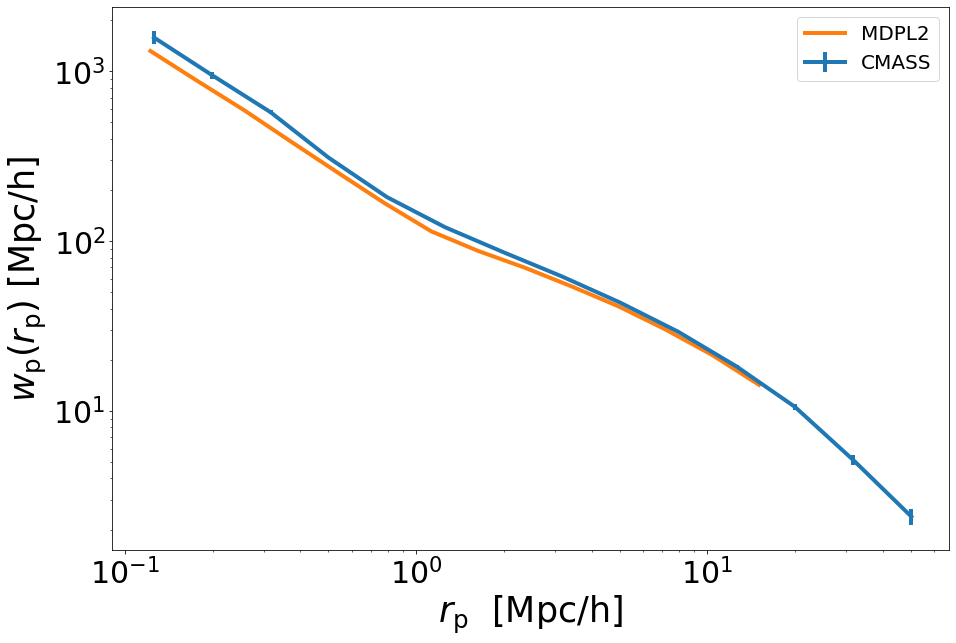

In [14]:
plt.figure(figsize=[15,10])
# plt.errorbar(wp_data['rp'],wp_data['wp'], yerr = wp_data['wp_err'], label='CMASS')
plt.errorbar(wp_correct_cosmology_data['rp'],wp_correct_cosmology_data['wp'],
             yerr = wp_correct_cosmology_data['wp_err'], label='CMASS', linewidth=4)

plt.plot(rp_bin_centers_wp, wp_no_displacement, label=r'MDPL2', linewidth=4)

plt.loglog()
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.xlabel(r'$r_{\rm p} $  $\rm{[Mpc/h]}$', fontsize=35)
plt.ylabel(r'$w_{\rm p}(r_{\rm p})$ $\rm{[Mpc/h]}$', fontsize=35)
# plt.title(r'$M_{\ast} > 10^{10.25}M_{\odot}$', fontsize=20)
plt.legend(loc='best', fontsize=20)
plt.show()

## measure weak lensing 

In [15]:
rp_bins_ds = np.logspace(-1, 1, 15)

particle_masses = halo_catalog.particle_mass
period=HOD_model.mock.Lbox
downsampling_factor = (halo_catalog.num_ptcl_per_dim**3)/float(len(particle_positions))

rp_centers_ds, ds_in_mpc = delta_sigma(galaxy_positions, particle_positions,
                    particle_masses, downsampling_factor,
                    rp_bins_ds, period, cosmology=Planck15, num_threads='max')

length_unit_conversion = 1e6
ds_in_pc_no_displacement = ds_in_mpc/length_unit_conversion**2

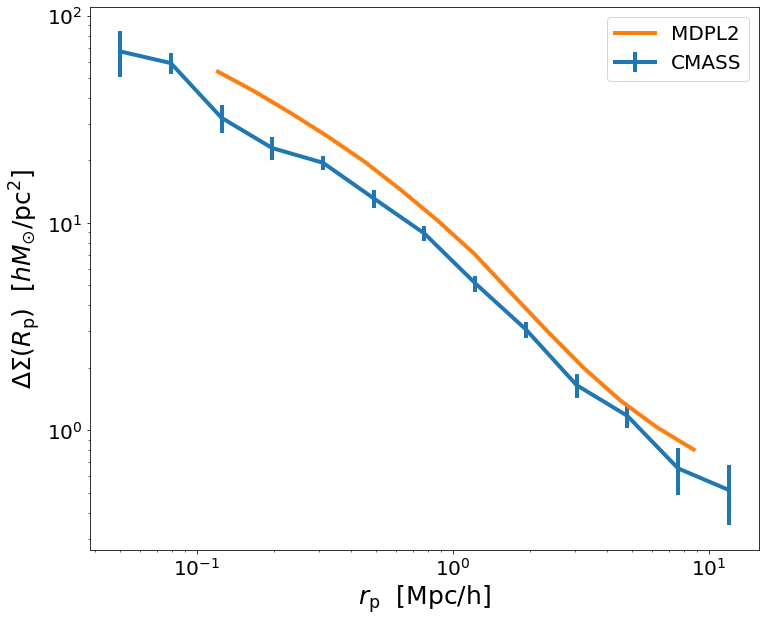

In [16]:
plt.figure(figsize=[12,10])
plt.errorbar(ds_data['rp'],ds_data['ds'], yerr = ds_data['ds_err'], label='CMASS', linewidth=4)
plt.plot(rp_centers_ds, ds_in_pc_no_displacement, label='MDPL2', linewidth=4)
plt.loglog()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel(r'$r_{\rm p} $  $\rm{[Mpc/h]}$', fontsize=25)
plt.ylabel(r'$\Delta\Sigma(R_{\rm p})$  $[h M_{\odot} / {\rm pc}^2]$', fontsize=25)
plt.legend(loc='best', fontsize=20)
plt.show()

# displaced particles 

Files read.
Creating catalogs...
populating mock


/Users/fardila/anaconda2/envs/baryonic_effects/lib/python3.7/site-packages/halotools/empirical_models/phase_space_models/analytic_models/monte_carlo_helpers.py:205: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  self.rad_prof_func_table_indices[digitized_param_list]
/Users/fardila/anaconda2/envs/baryonic_effects/lib/python3.7/site-packages/halotools/empirical_models/phase_space_models/analytic_models/monte_carlo_helpers.py:522: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  self.rad_prof_func_table_indices[digitized_param_list]


wp


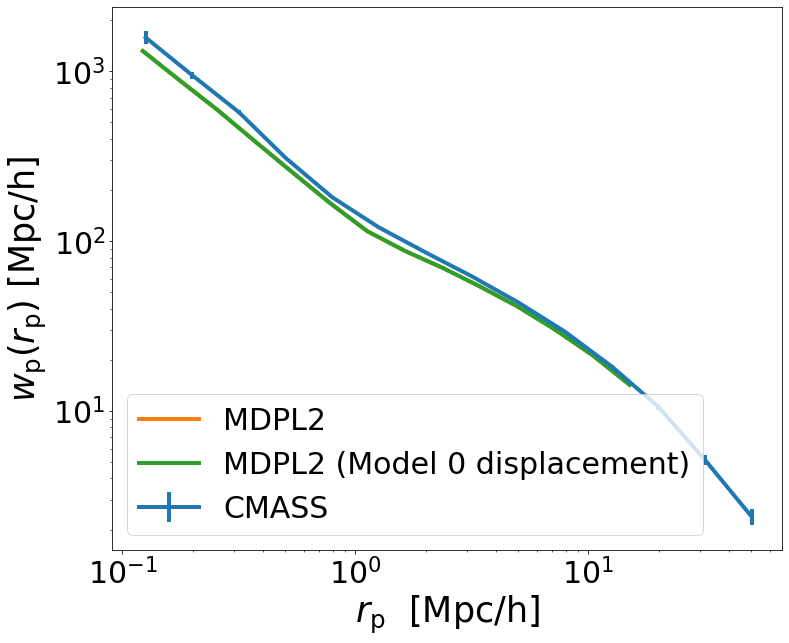

DELTA SIGMA
[0.12105159 0.16820065 0.23371404 0.3247446  0.45123117 0.62698367
 0.87119099 1.21051595 1.68200646 2.33714039 3.24744605 4.51231165
 6.26983671 8.71190986]


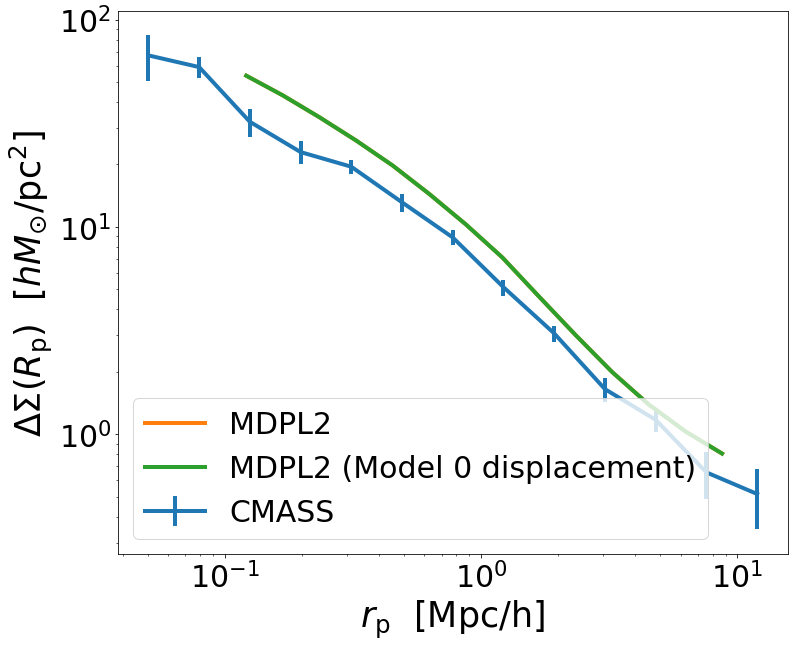

In [17]:
wp2, ds_in_pc_2 = from_catalogs_make_wp_DS_plots(data_directory+queried_halo_cat_file, 
                                                  data_directory+particle_cat_file, HOD_model, '0')

Files read.
Creating catalogs...
populating mock


/Users/fardila/anaconda2/envs/baryonic_effects/lib/python3.7/site-packages/halotools/empirical_models/phase_space_models/analytic_models/monte_carlo_helpers.py:205: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  self.rad_prof_func_table_indices[digitized_param_list]
/Users/fardila/anaconda2/envs/baryonic_effects/lib/python3.7/site-packages/halotools/empirical_models/phase_space_models/analytic_models/monte_carlo_helpers.py:522: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  self.rad_prof_func_table_indices[digitized_param_list]


wp


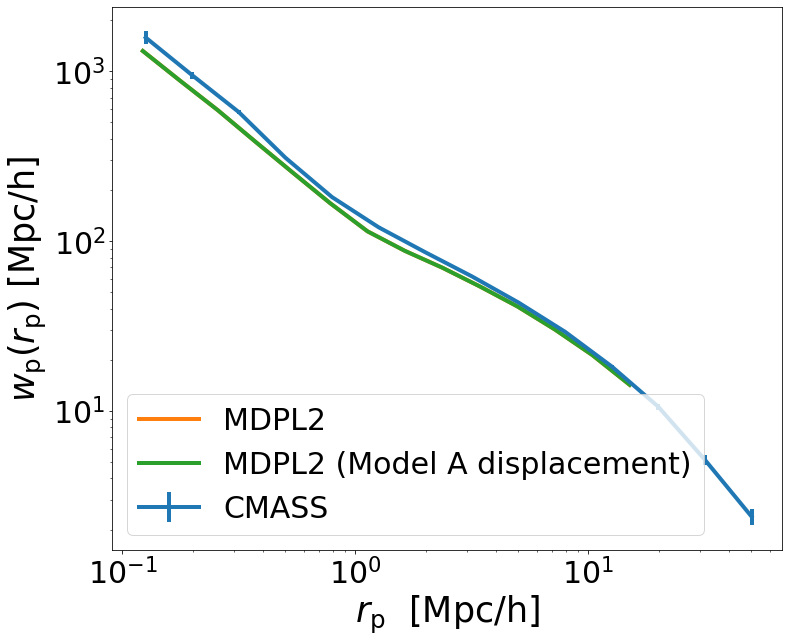

DELTA SIGMA
[0.12105159 0.16820065 0.23371404 0.3247446  0.45123117 0.62698367
 0.87119099 1.21051595 1.68200646 2.33714039 3.24744605 4.51231165
 6.26983671 8.71190986]


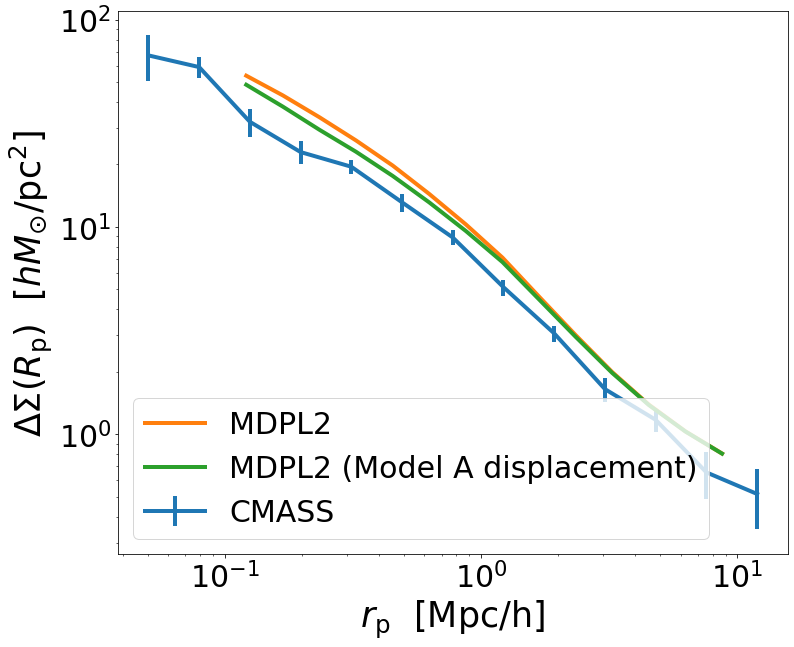

In [18]:
wp_A, ds_in_pc_A = from_catalogs_make_wp_DS_plots(data_directory+queried_halo_cat_file, 
                                                  data_directory+displacedA_particle_cat_file, HOD_model, 'A')

Files read.
Creating catalogs...
populating mock


/Users/fardila/anaconda2/envs/baryonic_effects/lib/python3.7/site-packages/halotools/empirical_models/phase_space_models/analytic_models/monte_carlo_helpers.py:205: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  self.rad_prof_func_table_indices[digitized_param_list]
/Users/fardila/anaconda2/envs/baryonic_effects/lib/python3.7/site-packages/halotools/empirical_models/phase_space_models/analytic_models/monte_carlo_helpers.py:522: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  self.rad_prof_func_table_indices[digitized_param_list]


wp


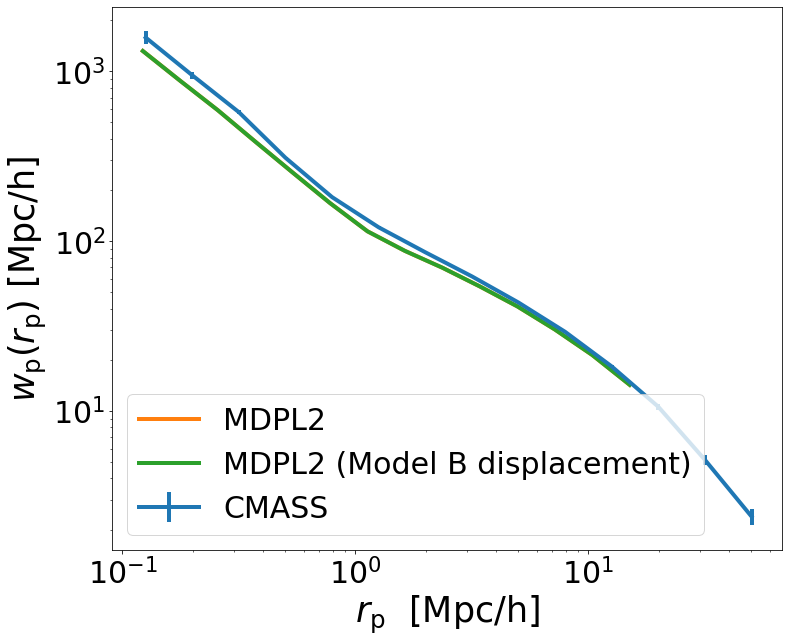

DELTA SIGMA
[0.12105159 0.16820065 0.23371404 0.3247446  0.45123117 0.62698367
 0.87119099 1.21051595 1.68200646 2.33714039 3.24744605 4.51231165
 6.26983671 8.71190986]


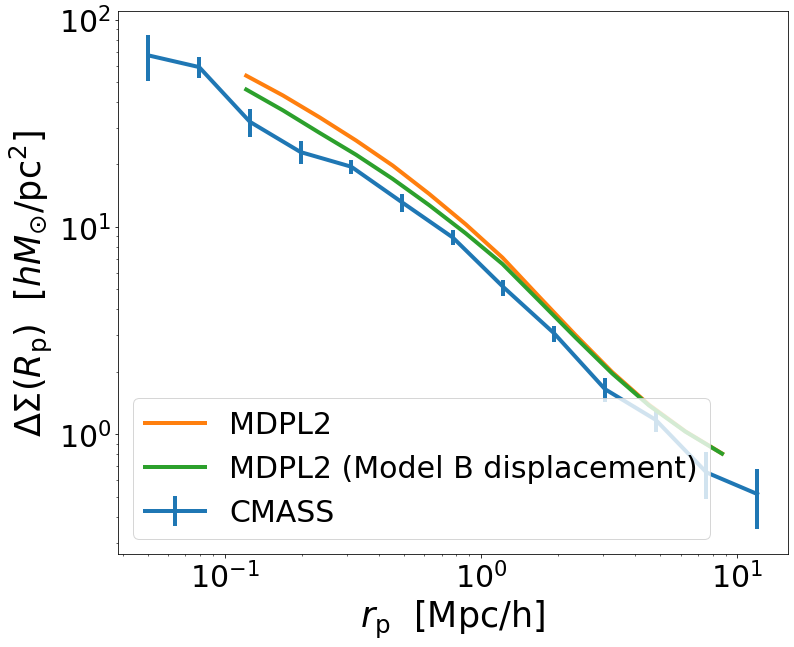

In [19]:
wp_B, ds_in_pc_B = from_catalogs_make_wp_DS_plots(data_directory+queried_halo_cat_file, 
                                                  data_directory+displacedB_particle_cat_file, HOD_model, 'B')

Files read.
Creating catalogs...
populating mock


/Users/fardila/anaconda2/envs/baryonic_effects/lib/python3.7/site-packages/halotools/empirical_models/phase_space_models/analytic_models/monte_carlo_helpers.py:205: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  self.rad_prof_func_table_indices[digitized_param_list]
/Users/fardila/anaconda2/envs/baryonic_effects/lib/python3.7/site-packages/halotools/empirical_models/phase_space_models/analytic_models/monte_carlo_helpers.py:522: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  self.rad_prof_func_table_indices[digitized_param_list]


wp


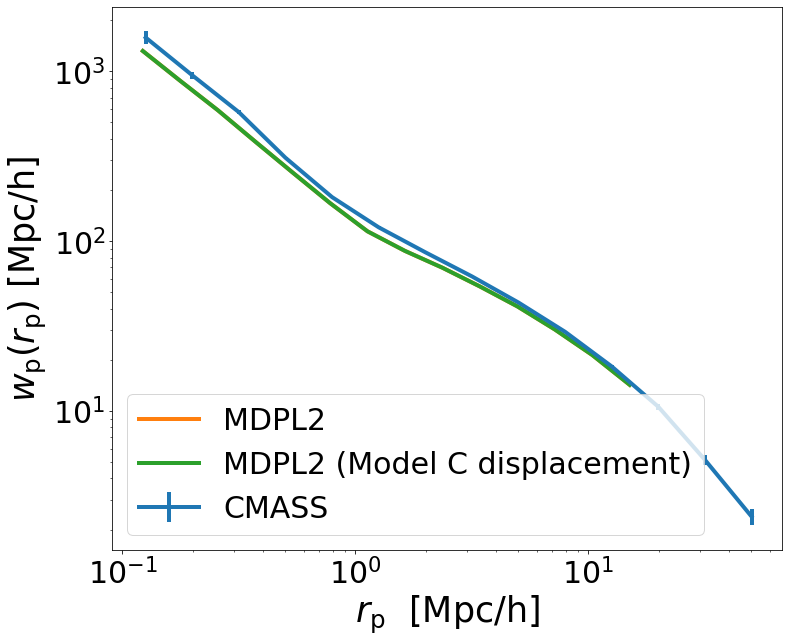

DELTA SIGMA
[0.12105159 0.16820065 0.23371404 0.3247446  0.45123117 0.62698367
 0.87119099 1.21051595 1.68200646 2.33714039 3.24744605 4.51231165
 6.26983671 8.71190986]


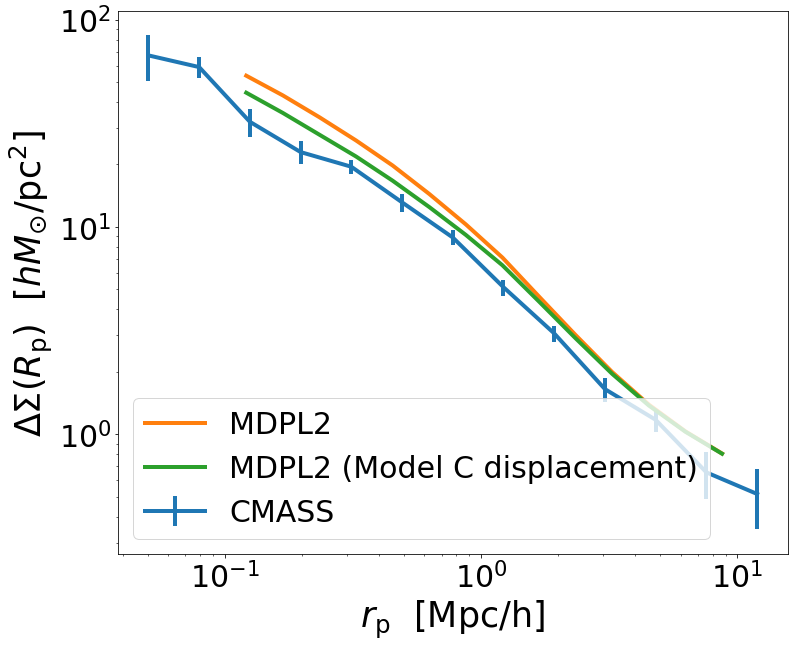

In [20]:
wp_C, ds_in_pc_C = from_catalogs_make_wp_DS_plots(data_directory+queried_halo_cat_file, 
                                                  data_directory+displacedC_particle_cat_file, HOD_model, 'C')

## plot for talk 

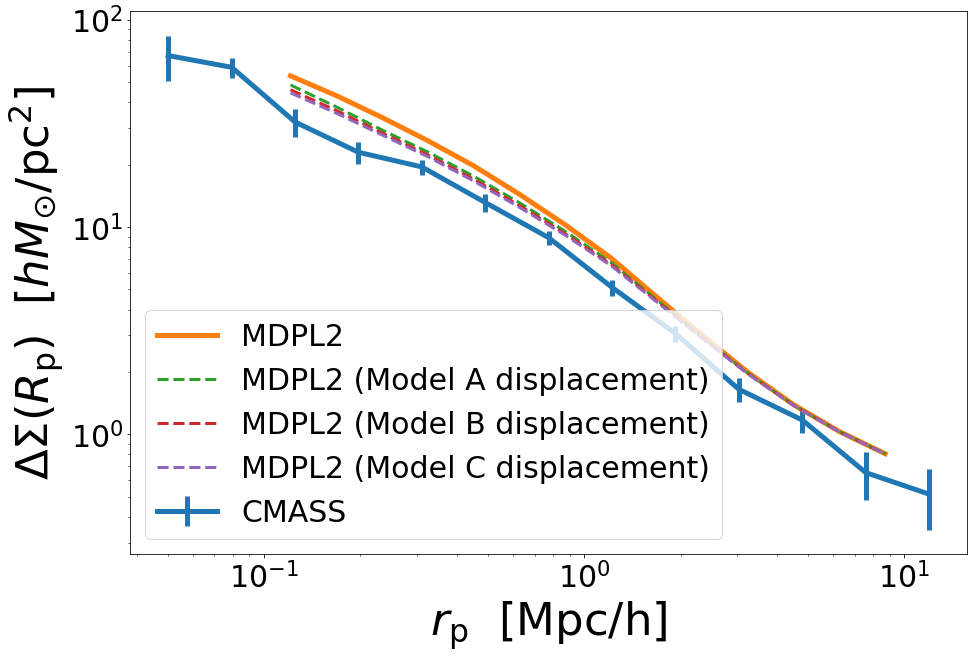

In [21]:
plt.figure(figsize=[15,10])

plt.errorbar(ds_data['rp'],ds_data['ds'], yerr = ds_data['ds_err'], label='CMASS', linewidth=5)
plt.plot(rp, ds_in_pc_no_displacement, label='MDPL2', linewidth=5)
plt.plot(rp, ds_in_pc_A, label='MDPL2 (Model A displacement)', linewidth=3, linestyle='--')
plt.plot(rp, ds_in_pc_B, label='MDPL2 (Model B displacement)', linewidth=3, linestyle='--')
plt.plot(rp, ds_in_pc_C, label='MDPL2 (Model C displacement)', linewidth=3, linestyle='--')

plt.loglog()
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.xlabel(r'$r_{\rm p} $  $\rm{[Mpc/h]}$', fontsize=45)
plt.ylabel(r'$\Delta\Sigma(R_{\rm p})$  $[h M_{\odot} / {\rm pc}^2]$', fontsize=45)
plt.legend(loc='best', fontsize=30)

# plt.savefig('DS_CMASS_MPDL2_displacement.pdf')
plt.show()

## plot ratios 

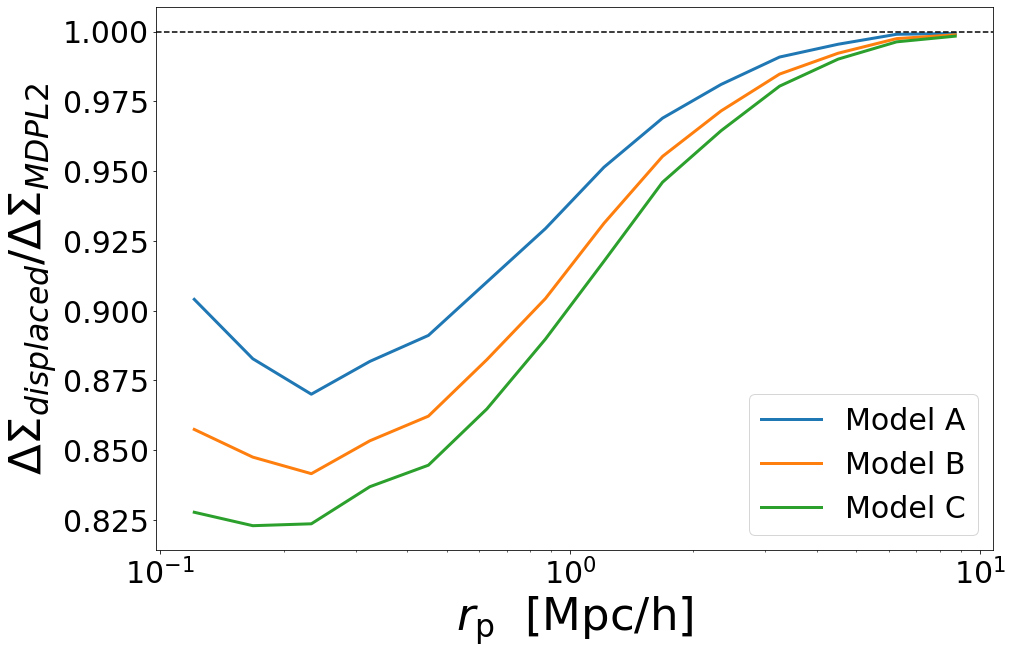

In [21]:
plt.figure(figsize=[15,10])


# plt.plot(rp, ds_in_pc_no_displacement, label='MDPL2', linewidth=5)
plt.plot(rp_centers_ds, ds_in_pc_A/ds_in_pc_no_displacement, label='Model A', linewidth=3)
plt.plot(rp_centers_ds, ds_in_pc_B/ds_in_pc_no_displacement, label='Model B', linewidth=3)
plt.plot(rp_centers_ds, ds_in_pc_C/ds_in_pc_no_displacement, label='Model C', linewidth=3)
plt.axhline(1, linestyle='--', color ='k')

plt.semilogx()
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.xlabel(r'$r_{\rm p} $  $\rm{[Mpc/h]}$', fontsize=45)
plt.ylabel(r'$\Delta\Sigma_{displaced}/ \Delta\Sigma_{MDPL2}$', fontsize=45)
plt.legend(loc='best', fontsize=30)

# plt.savefig('DS_CMASS_MPDL2_displacement.pdf')
plt.show()

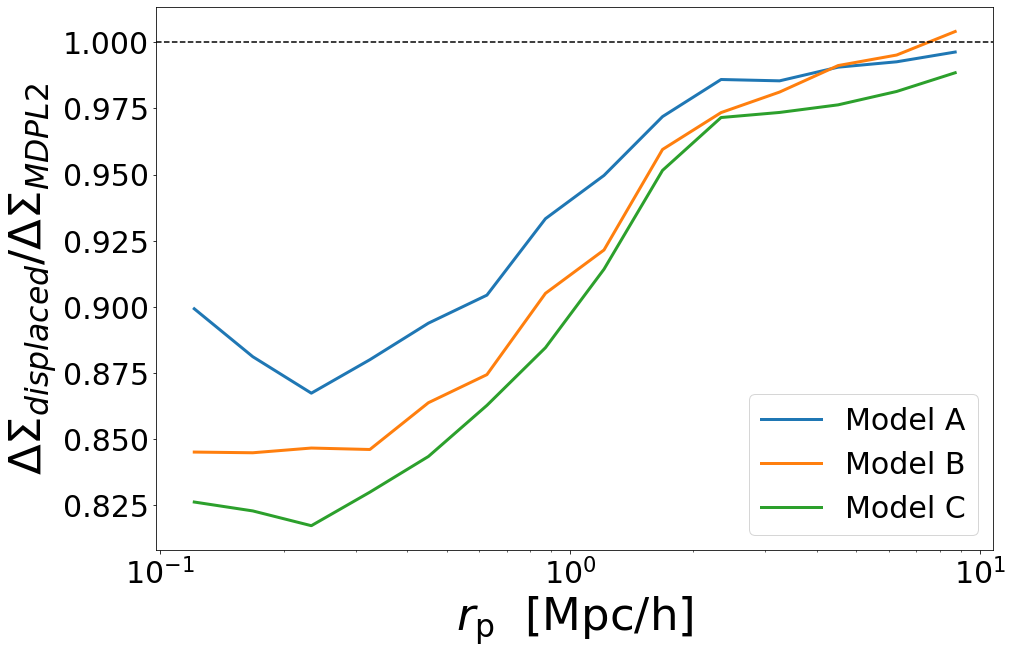

In [24]:
plt.figure(figsize=[15,10])


# plt.plot(rp, ds_in_pc_no_displacement, label='MDPL2', linewidth=5)
plt.plot(rp_centers_ds, ds_in_pc_A/ds_in_pc_no_displacement, label='Model A', linewidth=3)
plt.plot(rp_centers_ds, ds_in_pc_B/ds_in_pc_no_displacement, label='Model B', linewidth=3)
plt.plot(rp_centers_ds, ds_in_pc_C/ds_in_pc_no_displacement, label='Model C', linewidth=3)
plt.axhline(1, linestyle='--', color ='k')

plt.semilogx()
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.xlabel(r'$r_{\rm p} $  $\rm{[Mpc/h]}$', fontsize=45)
plt.ylabel(r'$\Delta\Sigma_{displaced}/ \Delta\Sigma_{MDPL2}$', fontsize=45)
plt.legend(loc='best', fontsize=30)

# plt.savefig('DS_CMASS_MPDL2_displacement.pdf')
plt.show()

## plot rDS 

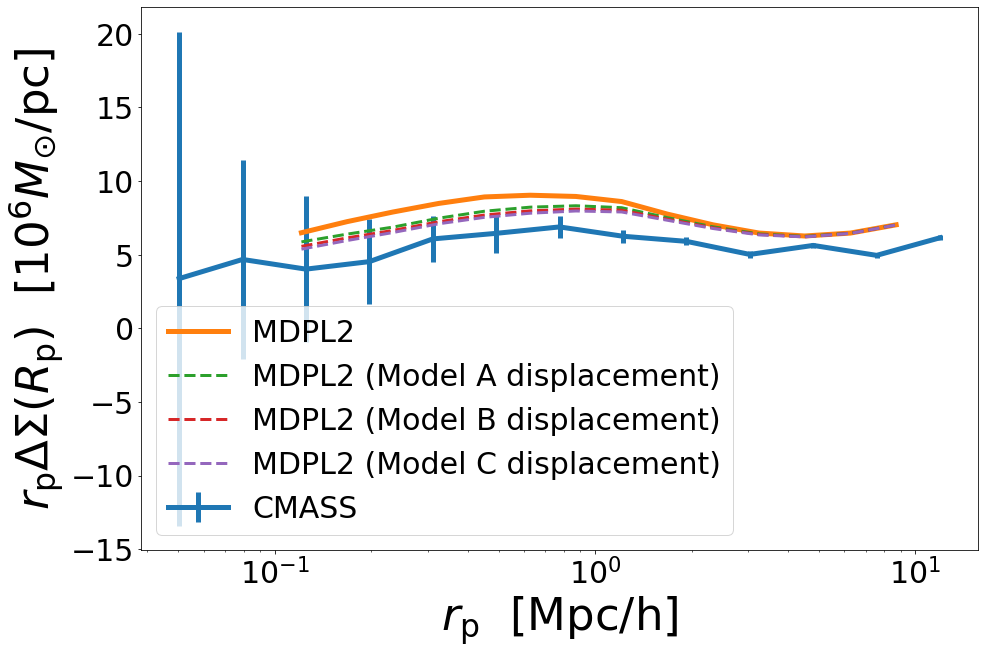

In [23]:
plt.figure(figsize=[15,10])

plt.errorbar(ds_data['rp'],ds_data['rp']*ds_data['ds'], yerr = ds_data['ds_err'], label='CMASS', linewidth=5)
plt.plot(rp, rp*ds_in_pc_no_displacement, label='MDPL2', linewidth=5)
plt.plot(rp, rp*ds_in_pc_A, label='MDPL2 (Model A displacement)', linewidth=3, linestyle='--')
plt.plot(rp, rp*ds_in_pc_B, label='MDPL2 (Model B displacement)', linewidth=3, linestyle='--')
plt.plot(rp, rp*ds_in_pc_C, label='MDPL2 (Model C displacement)', linewidth=3, linestyle='--')

plt.semilogx()
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.xlabel(r'$r_{\rm p} $  $\rm{[Mpc/h]}$', fontsize=45)
plt.ylabel(r'$r_{\rm p}\Delta\Sigma(R_{\rm p})$  $[10^6 M_{\odot} / {\rm pc}]$', fontsize=45)
plt.legend(loc='best', fontsize=30)

# plt.savefig('DS_CMASS_MPDL2_displacement.pdf')
plt.show()